# Scene Reconstruction

- Image Acquisition: Capture multiple images of the scene using the uncalibrated camera from different viewpoints. It's important to have sufficient image overlap to allow for accurate scene reconstruction.

- Feature Extraction: Extract distinctive features from the images. Common feature extraction techniques include corner detection, scale-invariant feature transform (SIFT), or speeded-up robust features (SURF). These features serve as reference points for matching and aligning the images.

- Image Matching: Pair up corresponding features between the images. This can be done using techniques like nearest-neighbor matching or RANSAC (Random Sample Consensus) to estimate the transformation between the images.

- Camera Pose Estimation: Estimate the camera poses for each image in the scene. The relative camera poses can be determined by triangulating the matched features and using algorithms such as the perspective-n-point (PnP) algorithm. This step helps establish the spatial relationships between the images.

- Bundle Adjustment: Refine the camera poses and feature positions using bundle adjustment. Bundle adjustment is an optimization process that minimizes the reprojection error between the observed features in the images and their corresponding 3D points in the scene. This step improves the overall accuracy of the scene reconstruction.

- Point Cloud Generation: Generate a 3D point cloud of the scene by triangulating the matched features across multiple images. Each point in the point cloud represents the 3D position of a feature in the scene.

- Mesh Generation (optional): If desired, the point cloud can be further processed to create a mesh representation of the scene. Mesh generation techniques, such as Delaunay triangulation or Poisson surface reconstruction, can be used to create a surface mesh from the point cloud data.

- Texturing (optional): Apply textures to the generated mesh using image-based texture mapping techniques. This step enhances the visual realism of the reconstructed scene by projecting the original images onto the mesh surface.

In [79]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [80]:
video_path = os.path.join(os.getcwd(), 'Dino.avi')
video = cv2.VideoCapture(video_path)
if not video.isOpened():
    print("Failed to open the video file.")
    exit()


### Retrieve Metadata

In [81]:
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration = frame_count / fps


print("Frame count:", frame_count)
print("FPS:", fps)
print("Width:", width)
print("Height:", height)
print("Duration:", duration, "seconds")


Frame count: 210
FPS: 31.579612202362156
Width: 878
Height: 824
Duration: 6.649859999999999 seconds


Generate frames from the video

In [82]:
os.makedirs('frames', exist_ok=True)

In [83]:
for frame_index in range(frame_count):
    ret, frame = video.read()
    if not ret:
        break
   # Save the frame as an image
    image_path = os.path.join('frames', f"frame_{frame_index}.jpg")
    cv2.imwrite(image_path, frame)

# Release the video capture object
video.release()
cv2.destroyAllWindows()

## Feature Extraction

Detect and extract distinctive features from the images. Use feature extraction algorithms like SIFT, SURF, or ORB to identify key points or regions.

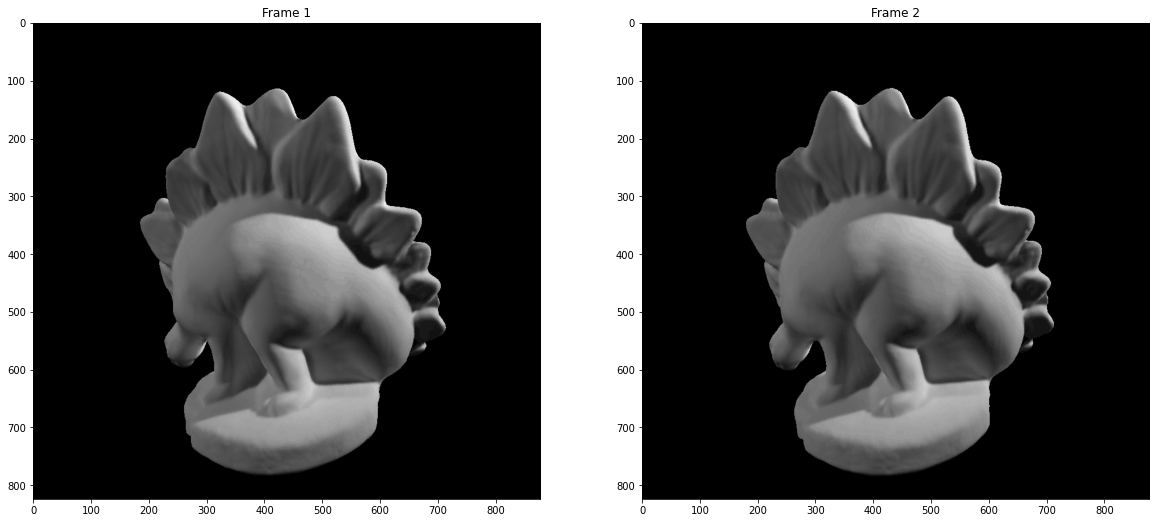

In [133]:
frames_path = os.path.join(os.getcwd(), 'frames')
frames = os.listdir(frames_path)

# load the first two frames
frame1 = cv2.imread(os.path.join(frames_path, frames[50]))
frame2 = cv2.imread(os.path.join(frames_path, frames[51]))

# convert to grayscale
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# display the frames
fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Frame 1")
plots[0].imshow(frame1_gray, cmap="gray")
plots[1].set_title("Frame 2")
plots[1].imshow(frame2_gray, cmap="gray")

Number of Keypoints Detected In The Training Image:  144
Number of Keypoints Detected In The Query Image:  170


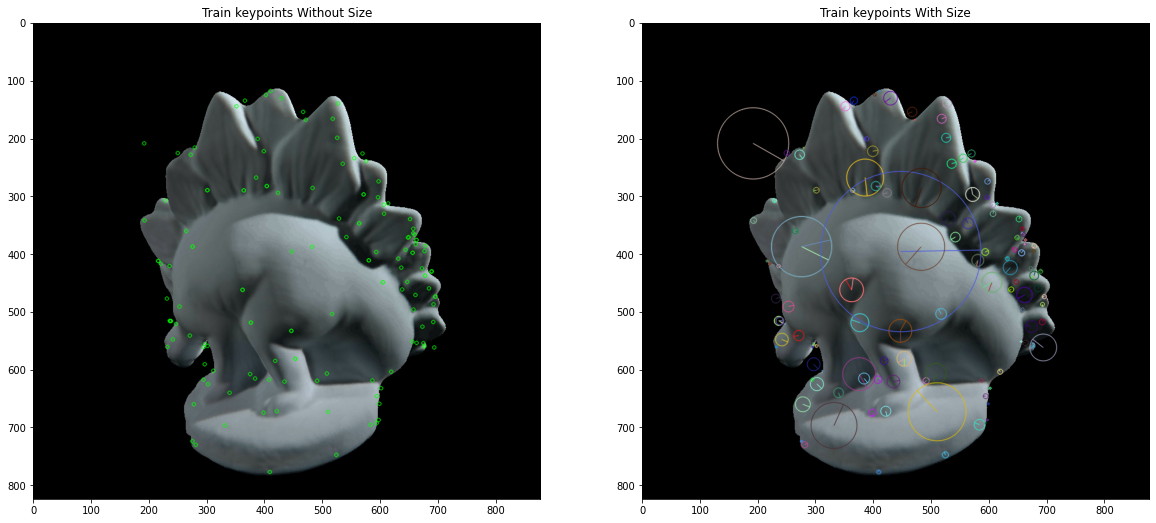

In [134]:
# detect the keypoints using SIFT
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT in each frame
kp1, des1 = sift.detectAndCompute(frame1_gray, None)
kp2, des2 = sift.detectAndCompute(frame2_gray, None)

keypoints_without_size = np.copy(frame1)
keypoints_with_size = np.copy(frame1)

cv2.drawKeypoints(frame1, kp1, keypoints_without_size, color = (0, 255, 0))
cv2.drawKeypoints(frame1, kp1, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Train keypoints Without Size")
plots[0].imshow(keypoints_without_size, cmap="gray")
plots[1].set_title("Train keypoints With Size")
plots[1].imshow(keypoints_with_size, cmap="gray")

# print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(kp1))
# print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(kp2))


### Matching Keypoints

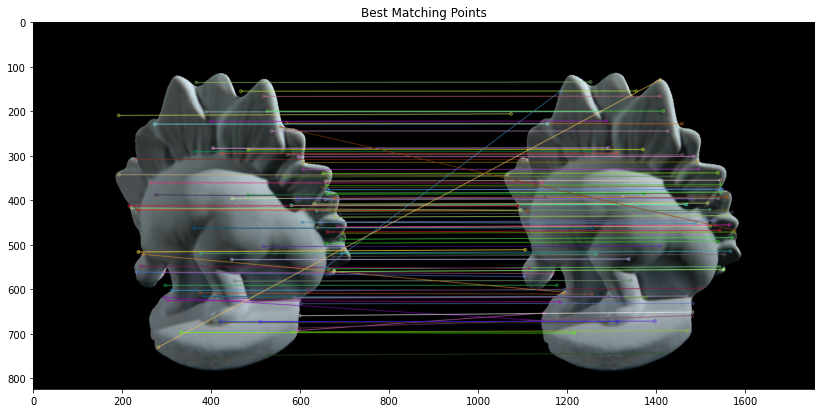


Number of Matching Keypoints Between The Training And Query Images:  101


In [135]:
# create a Brute force matcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(des1, des2)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(frame1, kp1, frame2, kp2, matches, None, flags = 2)

plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training And Query Images: ", len(matches))

Using uncalibrated stereo<br>
Using the features to get the transform from one image to the next<br>
Helps in generating the x,y,z coordinates for the 3D space<br>

### RANSAC algorithm

RANdom SAmple Consensus, an algorithm proposed for robust estimation of model parameters in presence of outliers (noisy and wrong data points)


Number of Inlier Matching Keypoints After RANSAC:  63


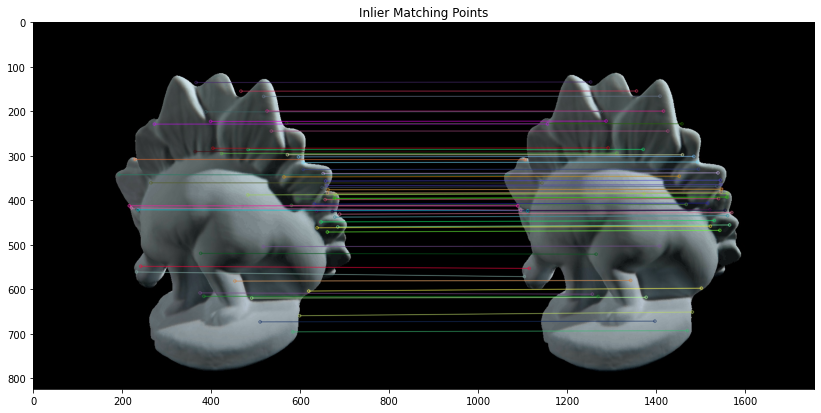

In [136]:
# RANSAC to find the best homography
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# RANSAC parameters
ransac_reproj_threshold = 5.0  # Adjust this threshold according to your application

# Find homography using RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_reproj_threshold)

# Apply the mask to get the inliers (good matches)
inliers = [matches[i] for i in range(len(matches)) if mask[i] == 1]

# Print total number of matching points between the training and query images after RANSAC
print("\nNumber of Inlier Matching Keypoints After RANSAC: ", len(inliers))

# Draw the inlier matches
result_inliers = cv2.drawMatches(frame1, kp1, frame2, kp2, inliers, None, flags=2)

plt.title('Inlier Matching Points')
plt.imshow(result_inliers)
plt.show()


### Camera Pose Estimation: 
Estimate the camera poses for each image in the scene. The relative camera poses can be determined by triangulating the matched features and using algorithms such as the perspective-n-point (PnP) algorithm. This step helps establish the spatial relationships between the images.

In [137]:
# If you don't have the camera matrix, you can use an identity matrix as a placeholder
K = np.eye(3)

# Use the Essential Matrix to estimate the camera pose
E, mask = cv2.findEssentialMat(src_pts, dst_pts, cameraMatrix=K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Recover the rotation and translation from the Essential Matrix
_, R, t, mask = cv2.recoverPose(E, src_pts, dst_pts, cameraMatrix=K)

# Print the rotation matrix and translation vector
print("Rotation Matrix:")
print(R)
print("\nTranslation Vector:")
print(t)

Rotation Matrix:
[[ 9.99993038e-01 -3.73127378e-03 -3.35674577e-05]
 [ 3.73127449e-03  9.99993039e-01  2.11117556e-05]
 [ 3.34884503e-05 -2.12368580e-05  9.99999999e-01]]

Translation Vector:
[[9.87226653e-01]
 [1.59321576e-01]
 [4.14656805e-04]]


### Reconstruction

In [ ]:
points_3d = []

# If you have the actual camera matrix, use it to construct the projection matrices
# Otherwise, you can use an identity matrix as a placeholder for the camera matrix

P1 = K.dot(np.hstack((np.eye(3), np.zeros((3, 1)))))
P2 = K.dot(np.hstack((R, t)))

# Triangulate the 3D points using the camera poses and matched keypoints
for i in range(len(matches)):
    # Get the pixel coordinates of the matched keypoints
    pt1 = np.array([kp1[matches[i].queryIdx].pt[0], kp1[matches[i].queryIdx].pt[1], 1])
    pt2 = np.array([kp2[matches[i].trainIdx].pt[0], kp2[matches[i].trainIdx].pt[1], 1])
    # print(pt1, '\n', pt2)
    # print(pt1.shape, pt2.shape)

    # Reshape the points for triangulation
    pt1 = pt1[:2]
    pt2 = pt2[:2]

    # print(pt1, '\n', pt2)
    # print(pt1.shape, pt2.shape)

    # Perform triangulation
    point_4d = cv2.triangulatePoints(P1, P2, pt1, pt2)
    point_3d = point_4d[:3] / point_4d[3]  # Normalize by the fourth coordinate

    # # Add the 3D point to the list
    points_3d.append(point_3d)

# Convert the list to NumPy array
points_3d = np.asarray(points_3d)

# Print the 3D points
print("3D Points:")
print(points_3d)

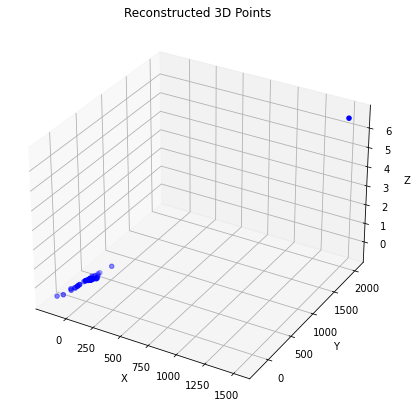

In [139]:
from mpl_toolkits.mplot3d import Axes3D

# Create a new 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates of the 3D points
x = points_3d[:, 0]
y = points_3d[:, 1]
z = points_3d[:, 2]

# Plot the 3D points as a scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot title
plt.title('Reconstructed 3D Points')

# Show the plot
plt.show()

Reconstructed 3D Points:
[[[ 3.50991615e+01]
  [ 3.24321434e+01]
  [ 8.22070369e-02]]

 [[ 2.18389945e+01]
  [ 3.62384186e+01]
  [ 5.25795772e-02]]

 [[-1.87292065e+03]
  [-1.25169890e+03]
  [-5.19962182e+00]]

 ...

 [[-1.33964727e+00]
  [-9.15339458e-01]
  [-1.83968307e-03]]

 [[-7.23487854e+00]
  [-3.80515401e+00]
  [-1.17495321e-02]]

 [[-6.38865136e+01]
  [-7.96821824e+01]
  [-1.72957692e-01]]]


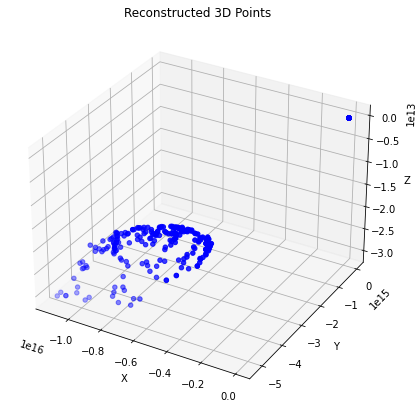

In [141]:
def reconstruct_3d_points(frame1, frame2):
    # Convert to grayscale
    frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Detect the keypoints using SIFT
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT in each frame
    kp1, des1 = sift.detectAndCompute(frame1_gray, None)
    kp2, des2 = sift.detectAndCompute(frame2_gray, None)

    # Create a Brute force matcher object
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    # Perform the matching between the SIFT descriptors of the training image and the test image
    matches = bf.match(des1, des2)

    # The matches with shorter distance are the ones we want.
    matches = sorted(matches, key=lambda x: x.distance)

    # RANSAC to find the best homography
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # RANSAC parameters
    ransac_reproj_threshold = 5.0  # Adjust this threshold according to your application

    # Find homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_reproj_threshold)

    # Apply the mask to get the inliers (good matches)
    inliers = [matches[i] for i in range(len(matches)) if mask[i] == 1]

    # If you don't have the camera matrix, you can use an identity matrix as a placeholder
    K = np.eye(3)

    # Use the Essential Matrix to estimate the camera pose
    E, mask = cv2.findEssentialMat(src_pts, dst_pts, cameraMatrix=K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    # Recover the rotation and translation from the Essential Matrix
    _, R, t, mask = cv2.recoverPose(E, src_pts, dst_pts, cameraMatrix=K)

    points_3d = []

    # If you have the actual camera matrix, use it to construct the projection matrices
    # Otherwise, you can use an identity matrix as a placeholder for the camera matrix
    P1 = K.dot(np.hstack((np.eye(3), np.zeros((3, 1)))))
    P2 = K.dot(np.hstack((R, t)))

    # Triangulate the 3D points using the camera poses and matched keypoints
    for i in range(len(matches)):
        # Get the pixel coordinates of the matched keypoints
        pt1 = np.array([kp1[matches[i].queryIdx].pt[0], kp1[matches[i].queryIdx].pt[1], 1])
        pt2 = np.array([kp2[matches[i].trainIdx].pt[0], kp2[matches[i].trainIdx].pt[1], 1])

        # Reshape the points for triangulation
        pt1 = pt1[:2]
        pt2 = pt2[:2]

        # Perform triangulation
        point_4d = cv2.triangulatePoints(P1, P2, pt1, pt2)
        point_3d = point_4d[:3] / point_4d[3]  # Normalize by the fourth coordinate

        # Add the 3D point to the list
        points_3d.append(point_3d)

    # Convert the list to a NumPy array
    points_3d = np.asarray(points_3d)

    return points_3d

# Define the path to the frames folder
frames_path = os.path.join(os.getcwd(), 'frames')
frames = os.listdir(frames_path)

# Create a list to store the reconstructed 3D points from all frames
all_points_3d = []

# Iterate through each pair of consecutive frames
for i in range(len(frames) - 1):
    # Load the frames
    frame1 = cv2.imread(os.path.join(frames_path, frames[i]))
    frame2 = cv2.imread(os.path.join(frames_path, frames[i + 1]))

    # Reconstruct 3D points for the current frame pair
    points_3d = reconstruct_3d_points(frame1, frame2)

    # Add the points to the list
    all_points_3d.append(points_3d)

# Concatenate the points from all frames into a single array
all_points_3d = np.concatenate(all_points_3d, axis=0)

# Print the 3D points
print("Reconstructed 3D Points:")
print(all_points_3d)

# Create a new 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates of the 3D points
x = all_points_3d[:, 0]
y = all_points_3d[:, 1]
z = all_points_3d[:, 2]

# Plot the 3D points as a scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot title
plt.title('Reconstructed 3D Points')

# Show the plot
plt.show()


In [157]:
import plotly.graph_objects as go
import numpy as np

# Assuming your data is stored in the variable all_points_3d
# Reshape the data from (11159, 3, 1) to (11159, 3)
all_points_3d = all_points_3d.reshape(11159, 3)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=all_points_3d[:, 0],
    y=all_points_3d[:, 1],
    z=all_points_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
    )
)])

# Set axis labels
fig.update_layout(scene=dict(
    xaxis_title='X Axis Title',
    yaxis_title='Y Axis Title',
    zaxis_title='Z Axis Title'
))

# Show the plot
fig.show()


### Point Cloud filtering
Filtering techniques to remove noise and outliers from the point cloud data. This step helps improve the quality of the reconstructed scene.